1. Download Data, model and Preprocessing

Cần thay đổi chỗ này thành download video của BTC (hiện tại đang là video test của nhóm)

In [ ]:
!gdown --id '1nnCAtnAdSBAyw22JJVqArZHApBfW5vvo'
!unzip 'round2_test.zip'

Download model YoloV9 to preprocessing

In [ ]:
!gdown --id '1n3BpG0glA_jgBQLyi3jKE4tlBTi2l83B'

PREPROCESSING USING YOLOV9

In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

In [11]:
import torch
from models.common import DetectMultiBackend
from utils.general import non_max_suppression, scale_boxes
from utils.torch_utils import select_device, smart_inference_mode
import cv2  # Import OpenCV
import numpy as np  # Ensure numpy is imported

# Correctly placed letterbox function
def letterbox(img, new_shape=(640, 640), color=(0, 0, 0)):
    """Resize image to a 32-pixel-multiple rectangle"""
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # width, height deltas
    dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # divide padding into 2 sides
    dw /= 2
    dh /= 2
    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = round(dh - 0.1), round(dh + 0.1)
    left, right = round(dw - 0.1), round(dw + 0.1)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img

@smart_inference_mode()
def run_object_detection_video(weights='/content/best_workout_4.pt',
                               source='./data_mae/train/lateral raise/lateral_raise_6.MOV',
                               imgsz=(640, 640),
                               conf_thres=0.5,
                               iou_thres=0.5,
                               device='0',
                               classes=None,
                               agnostic_nms=False):
    # Setup
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=False)

    # Video capture
    vid_cap = cv2.VideoCapture(source)
    assert vid_cap.isOpened(), f'Failed to open video {source}'

    # List to store detections for each frame, including the frame number
    frame_detections = []

    frame_number = 0  # Initialize frame counter

    total_frames = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = vid_cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / original_fps
    # Tính toán phần trăm và thời điểm bắt đầu, kết thúc để cắt
    if duration > 60:
        start_percent = 15
        end_percent = 85
    elif duration > 10:
        start_percent = 10
        end_percent = 90
    else:
        start_percent = 0
        end_percent = 100

    start_frame = int((start_percent / 100) * total_frames)
    end_frame = int((end_percent / 100) * total_frames)
    current_frame = 0
    # Process each frame
    while True:
        ret, frame = vid_cap.read()
        current_frame+=1
        if not ret:
            break
        if start_frame <= current_frame <= end_frame:
            # Convert BGR (OpenCV format) to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Resize and pad frame to model input size
            img = letterbox(frame, new_shape=imgsz)
            img = img.transpose((2, 0, 1))  # HWC to CHW
            img = np.ascontiguousarray(img)

            img = torch.from_numpy(img).to(device).float() / 255.0
            img = img[None]  # add batch dimension

            pred = model(img, augment=False, visualize=False)
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)

            detections = []
            for i, det in enumerate(pred):  # detections per frame
                if len(det):
                    det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], frame.shape).round()

                    for *xyxy, conf, cls in reversed(det):
                        bbox = tuple(c.item() for c in xyxy)  # Convert bbox coordinates to tuple of floats
                        # Now including frame_number in the detection information
                        detections.append((cls.item(), conf.item(), bbox, current_frame))

            if detections:  # If there are detections in the current frame
                frame_detections.append(detections)

    vid_cap.release()
    return frame_detections

Function resize video

In [12]:
import cv2

def crop_and_resize_frames(input_video_path, output_video_path, predictions):
    # Mở video gốc
    cap = cv2.VideoCapture(input_video_path)

    # Lấy thông số frame rate và định dạng size của video
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (224, 224))
    frame_id = 1
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if 1:
            largest_bbox = None
            max_area = 0
            for pred in predictions:
                if pred[0][3] == frame_id:  # Kiểm tra frame_id của prediction
                    _, _, bbox, _ = pred[0]
                    x_min, y_min, x_max, y_max = bbox
                    area = (x_max - x_min) * (y_max - y_min)
                    if area > max_area:
                        max_area = area
                        largest_bbox = bbox
            if largest_bbox is not None:
                x_min, y_min, x_max, y_max = largest_bbox
                cropped_frame = frame[int(y_min):int(y_max), int(x_min):int(x_max)]
            else:
                # Nếu không có bbox, lấy toàn bộ khung hình
                cropped_frame = frame

            # Resize khung hình về 224x224
            resized_frame = cv2.resize(cropped_frame, (224, 224))

            # Viết frame đã chỉnh sửa vào file output
            out.write(resized_frame)

        frame_id += 1

    # Giải phóng và đóng tất cả
    cap.release()
    out.release()

Cần thay đổi ***data_dir*** là đường dẫn tới folder chứa các video test, ***output_dir*** nên giữ nguyên

In [13]:
import os

data_dir = "/content/content/drive/MyDrive/AI4LIFE2024-DATA/Test - Vòng loại"
output_dir = "/content/ss4"
from pathlib import Path; Path(output_dir).mkdir(parents=True, exist_ok=True)
i = 0
for video_file in os.listdir(data_dir):
            input_video_path = os.path.join(data_dir, video_file)
            filename_without_extension, _ = os.path.splitext(video_file)
            output_video_path = f"{output_dir}/{filename_without_extension}.mp4"
            print(filename_without_extension)
            video_detections = run_object_detection_video(source=input_video_path)
            crop_and_resize_frames(input_video_path, output_video_path, video_detections)
            i+=1
            if i==7:
              break

YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



chest fly machine_3


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



hip thrush_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



decline bench press_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



t bat row_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



push-up_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



squat_2


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



hip thrust_1


Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs


Để inference thì các video phải nằm trong các thư mục (sai nhãn vẫn được nên chúng tôi random sao cho 1 thư mục có ít nhất 1 video)

In [14]:
cd '/content'

/content


Tên các folder lúc train chúng tôi khác với BTC nên inference tôi cũng để tên folder như vậy, chúng tôi sẽ có bước chuẩn hóa trước khi ghi vào file csv

In [15]:
import os

# Root directory name
root_dir = "Workout_Exercises"

# List of exercises - directory names
exercises = [
    "barbell biceps curl", "bench press", "chest fly machine", "dbp",
    "deadlift", "hammer curl", "hip thrust", "incline bench press",
    "lat pulldown", "lateral raise", "leg extension", "leg raises",
    "plank", "pull up", "push-up", "romanian deadlift", "russian twist",
    "shoulder press", "squat", "t bar row", "tricep dips", "tricep pushdown"
]

# Create root directory
os.makedirs(root_dir, exist_ok=True)

# Create each exercise directory within the root directory
for exercise in exercises:
    os.makedirs(os.path.join(root_dir, exercise), exist_ok=True)

"Directories created successfully."

'Directories created successfully.'

In [16]:
!gdown --id '12myvrR4hpmk_V-LCbGO_JRRaoL6hento'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12myvrR4hpmk_V-LCbGO_JRRaoL6hento
To: /content/bonus.mp4
100% 107k/107k [00:00<00:00, 115MB/s]


In [ ]:
import os
import shutil

# Đường dẫn đến thư mục chứa video và thư mục đích
source_dir = 'ss4'
destination_dir = 'Workout_Exercises'

# Lấy danh sách tất cả các video trong thư mục nguồn
videos = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# Lấy danh sách tất cả các thư mục con trong thư mục đích
subdirectories = [d for d in os.listdir(destination_dir) if os.path.isdir(os.path.join(destination_dir, d))]

for i, video in enumerate(videos):
        destination_subdir = os.path.join(destination_dir, subdirectories[i % len(subdirectories)])
        source_video_path = os.path.join(source_dir, video)
        destination_video_path = os.path.join(destination_subdir, video)

        # Di chuyển video
        shutil.move(source_video_path, destination_video_path)
        print(f'Moved "{video}" to "{destination_subdir}"')
if len(videos) < len(subdirectories):
      for sub in subdirectories:
          full_sub_dir = f"{destination_dir}/{sub}"
          if len(os.listdir(full_sub_dir)) == 0:
              bonus_path = os.path.join(full_sub_dir, 'bonus.mp4')
              shutil.copy('./bonus.mp4', bonus_path)
              # Đổi tên file bonus sau khi sao chép
              new_bonus_name = f"bonus{sub}.mp4"
              new_bonus_path = os.path.join(full_sub_dir, new_bonus_name)
              os.rename(bonus_path, new_bonus_path)
              print(f'Renamed "bonus.mp4" to "{new_bonus_name}" in "{full_sub_dir}"')

PROCESSING, nếu có yêu cầu cần restart (hoặc gặp thông báo lỗi) thì cứ restart và tiếp tục chạy tiếp (không cần chạy lại từ trên xuống)

In [ ]:
!pip install transformers datasets
!pip install -q pytorchvideo evaluate

In [ ]:
!pip install torchvision==0.14.1

In [1]:
import os

# Define the root directory of your dataset
dataset_root = '/content/Workout_Exercises'

# Initialize an empty list to store the paths of all video files
all_video_file_paths = []

# Walk through the directory structure
for root, dirs, files in os.walk(dataset_root):
    for file in files:
        # Check if the file is a video file by its extension (assuming .mp4)
        if 1:
            # Construct the full path of the file
            full_path = os.path.join(root, file)
            # Append the full path to the list
            all_video_file_paths.append(full_path)
print(all_video_file_paths)

['/content/Workout_Exercises/tricep pushdown/chest fly machine_3.mp4', '/content/Workout_Exercises/plank/hip thrush_1.mp4', '/content/Workout_Exercises/push-up/decline bench press_2.mp4', '/content/Workout_Exercises/dbp/t bat row_1.mp4', '/content/Workout_Exercises/hip thrust/push-up_1.mp4', '/content/Workout_Exercises/squat/squat_2.mp4', '/content/Workout_Exercises/pull up/hip thrust_1.mp4', '/content/Workout_Exercises/russian twist/bonusrussian twist.mp4', '/content/Workout_Exercises/chest fly machine/bonuschest fly machine.mp4', '/content/Workout_Exercises/romanian deadlift/bonusromanian deadlift.mp4', '/content/Workout_Exercises/leg raises/bonusleg raises.mp4', '/content/Workout_Exercises/t bar row/bonust bar row.mp4', '/content/Workout_Exercises/incline bench press/bonusincline bench press.mp4', '/content/Workout_Exercises/hammer curl/bonushammer curl.mp4', '/content/Workout_Exercises/lat pulldown/bonuslat pulldown.mp4', '/content/Workout_Exercises/bench press/bonusbench press.mp4

In [ ]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

In [3]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    RandomAffine,
    ColorJitter
)

Load model được lưu ở Hugging Face

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "bluebird089/videomae-base-finetuned-kinetics-finetuned-round2-v4"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

In [5]:
mean = image_processor.image_mean
std = image_processor.image_std

num_frames_to_sample = model.config.num_frames

clip_duration = 3

In [6]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((224,224)),
                ]
            ),
        ),
    ]
)

import shutil
checkpoints_path = '/content/Workout_Exercises/.ipynb_checkpoints'
shutil.rmtree(checkpoints_path, ignore_errors=True)

# Now, you can load your dataset as before
test_dataset = pytorchvideo.data.Ucf101(
    data_path='/content/Workout_Exercises',
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [7]:
print(test_dataset.num_videos)

22


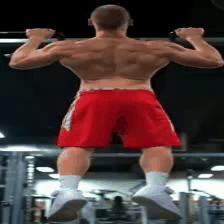

In [8]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(test_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

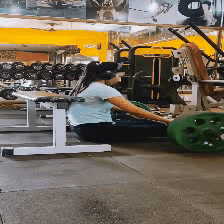

In [9]:
sample_test_video = next(iter(test_dataset))
video_tensor = sample_test_video["video"]
video_name = sample_test_video["video_name"]
video_label = id2label[sample_test_video["label"]]
display_gif(video_tensor)

Hậu xử lý, vì mô hình chúng tôi chia nhỏ video đầu vào thành các video có thời lượng ngắn nên cần biết sau khi tách nhỏ video nhỏ thuộc video lớn nào, predicted sẽ là số lần xuất hiện nhiều nhất

In [10]:
videos = []
labels = []
video_names = []
for sample in test_dataset:
    video_tensor = sample["video"]
    video_label = id2label[sample["label"]]
    video_name = sample["video_name"]
    videos.append(video_tensor)
    labels.append(video_label)
    video_names.append(video_name)


In [11]:
import torch
def run_inference(model, video, label):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        # "labels": torch.tensor(
        #     [label]
        # ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [12]:
predicted = []
for index in range(len(videos)):
  logits = run_inference(model, videos[index], labels[index])
  predicted_class_idx = logits.argmax(-1).item()
  predicted.append(model.config.id2label[predicted_class_idx])

In [13]:
# Chuyển đổi list thành set để loại bỏ các phần tử trùng lặp
S = set(video_names)

print(S.__len__())


22


Print thử kết quả, trước khi ghi vào file CSV chúng tôi cần chuẩn hóa tên 1 vài class để đảm bảo giống BTC

In [14]:
def changeName(label):
  if label == 'dbp':
    return 'decline bench press'
  elif label == 'tricep pushdown':
    return 'tricep Pushdown'
  elif label == 'pull up':
    return 'pull Up'
  else:
    return label

Vui lòng sửa ***data_dir*** là thư mục chứa video test của BTC

In [15]:
import os

data_dir = "/content/content/drive/MyDrive/AI4LIFE2024-DATA/Test - Vòng loại"

def getVideoName(videoName):
  base_name = videoName.split('.')[0]
  for name in os.listdir(data_dir):
        if name.split('.')[0] == base_name:
              return name
  return 'Error'

Lưu kết quả vào file result.csv

In [16]:
from collections import Counter
import csv
# List để lưu các id (vị trí) của phần tử từ S trong L
indices = []

filename = "result.csv"
with open(filename, 'w', newline='') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(['video', 'Dự đoán'])
  for item in S:
    if 'bonus' not in item:
     try:
        # print(item)
        # Lặp qua từng phần tử của S và tìm id của nó trong L
        # Lưu ý: Vòng lặp dưới đây sẽ tìm tất cả các vị trí của item trong L
        indices = [i for i, x in enumerate(video_names) if x == item]
        # print(indices)
        values = [predicted[i] for i in indices]

        # Sử dụng Counter để thống kê và tìm giá trị xuất hiện nhiều nhất
        most_common_value, count = Counter(values).most_common(1)[0]

        # print(f'Giá trị xuất hiện nhiều nhất là: {most_common_value} với {count}/{indices.__len__()} lần xuất hiện - label {item}')
        value = changeName(most_common_value)
        videoName = getVideoName(item)
        csvwriter.writerow([videoName, value])
        indices = []
     except ValueError:
        # Nếu phần tử không tồn tại trong L, bỏ qua
        continue